In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder

In [2]:
# 读取数据
data = pd.read_csv(r'D:\ArcgisData\pred_organic\feature_table_result\P_result.csv')
data.shape

(6805, 22)

In [3]:
# 删除缺失值
# 删除有缺失值的行
data.dropna(inplace=True)
data.shape

(6805, 22)

In [4]:
data.columns,len(data.columns)

(Index(['GD_point', 'X', 'Y', 'P', 'ASP_Band_1', 'CUR_Band_1', 'DEM_Band_1',
        'DL_Band_1', 'DZ_Band_1', 'NDVI_Band_1', 'NIGTH_Band_1', 'PLCUR_Band_1',
        'POCUR_Band_1', 'PRE_Band_1', 'SLOP_Band_1', 'SOILQS_Band_1',
        'TMP_Band_1', 'TPI_101_Band_1', 'TPI_11_Band_1', 'TPI_201_Band_1',
        'TPI_3_Band_1', 'TWI_5_Band_1'],
       dtype='object'),
 22)

In [5]:
data.drop(['GD_point'], axis=1, inplace=True)
data.columns

Index(['X', 'Y', 'P', 'ASP_Band_1', 'CUR_Band_1', 'DEM_Band_1', 'DL_Band_1',
       'DZ_Band_1', 'NDVI_Band_1', 'NIGTH_Band_1', 'PLCUR_Band_1',
       'POCUR_Band_1', 'PRE_Band_1', 'SLOP_Band_1', 'SOILQS_Band_1',
       'TMP_Band_1', 'TPI_101_Band_1', 'TPI_11_Band_1', 'TPI_201_Band_1',
       'TPI_3_Band_1', 'TWI_5_Band_1'],
      dtype='object')

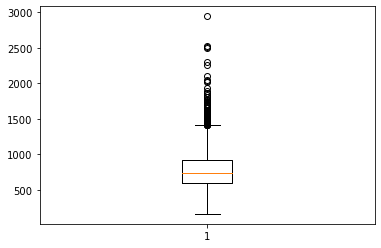

(6805, 21)


In [7]:
plt.boxplot(data["P"])
plt.show()
print(data.shape)

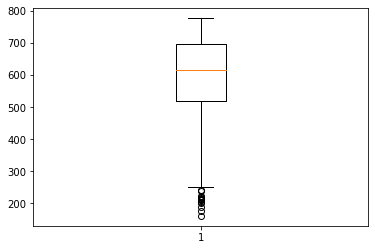

(3773, 21)


In [8]:
# 剔除离群值(3倍std)
outlier_threshold = data["P"].std()*3
s3_filter_data = data[abs(data['P']) < outlier_threshold]
s3_filter_data
plt.boxplot(s3_filter_data["P"])
plt.show()
print(s3_filter_data.shape)

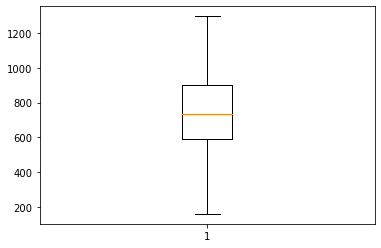

(6558, 21)


In [9]:
# 剔除离群值（Z-score）
z_scores = (data["P"]-data["P"].mean())/data["P"].std()
z_scores.describe()
# 设置阈值
z_score_filter= 2
z_filter_data = data[z_scores<z_score_filter]
z_filter_data
plt.boxplot(z_filter_data["P"])
plt.show()
print(z_filter_data.shape)

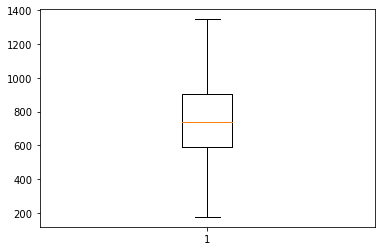

(6621, 21)


In [10]:
# 剔除离群值(IQR)
q1 = data['P'].quantile(0.25)
q3 = data['P'].quantile(0.75)
iqr = q3-q1
iqr_threshold = 1.3*iqr # 阈值1
iqr_filtered_data = data[(data['P'] >= q1 - iqr_threshold) & (data['P'] <= q3 + iqr_threshold)]
iqr_filtered_data
plt.boxplot(iqr_filtered_data["P"])
plt.show()
print(iqr_filtered_data.shape)

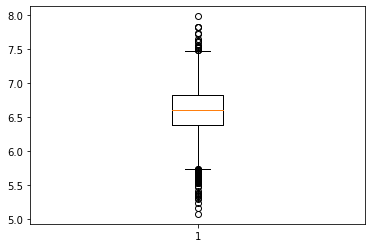

(6805, 21)


In [11]:
# log
log_data= data["P"].apply(np.log)
log_data
plt.boxplot(log_data)
plt.show()
print(data.shape)

In [12]:
data['P'].describe()

count    6805.000000
mean      777.439089
std       258.828423
min       161.000000
25%       597.000000
50%       744.000000
75%       924.000000
max      2945.000000
Name: P, dtype: float64

In [13]:
# 将label取为对数做训练
# data['organic'] = data['organic'].apply(np.log)
# 取iqr化后的数据做训练
data = iqr_filtered_data
data.shape

(6621, 21)

In [14]:
data['P'].describe()

count    6621.000000
mean      756.128681
std       224.195496
min       176.000000
25%       593.000000
50%       736.000000
75%       907.000000
max      1347.000000
Name: P, dtype: float64

In [15]:
# 重命名列名称
new_colums = {"ASP_Band_1":"ASP","CUR_Band_1":"CUR","DEM_Band_1":"DEM","DL_Band_1":"DL","DZ_Band_1":"DZ","NDVI_Band_1":"NDVI","NIGTH_Band_1":"NIGHT","PLCUR_Band_1":"PLCUR","POCUR_Band_1":"POCUR","PRE_Band_1":"PRE","SLOP_Band_1":"SLOPE",
              "SOILQS_Band_1":"SOILQS","TMP_Band_1":"TMP","TPI_101_Band_1":"TPI101","TPI_11_Band_1":"TPI11","TPI_201_Band_1":"TPI201","TPI_3_Band_1":"TPI3","TWI_5_Band_1":"TWI5"}
data.rename(columns=new_colums,inplace=True)
data.columns,len(data.columns)

<ipython-input-15-3532e88dc585>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns=new_colums,inplace=True)


(Index(['X', 'Y', 'P', 'ASP', 'CUR', 'DEM', 'DL', 'DZ', 'NDVI', 'NIGHT',
        'PLCUR', 'POCUR', 'PRE', 'SLOPE', 'SOILQS', 'TMP', 'TPI101', 'TPI11',
        'TPI201', 'TPI3', 'TWI5'],
       dtype='object'),
 21)

In [16]:
data['DZ'].describe(),data['DL'].describe()

(count    6621.000000
 mean        3.663042
 std         2.468143
 min         1.000000
 25%         2.000000
 50%         2.000000
 75%         6.000000
 max         8.000000
 Name: DZ, dtype: float64,
 count    6621.000000
 mean        5.697931
 std         3.747705
 min         1.000000
 25%         3.000000
 50%         7.000000
 75%         7.000000
 max        33.000000
 Name: DL, dtype: float64)

In [17]:
# 将类别特征值热编码
# hot_code = OneHotEncoder(sparse_output=True)
# hot_dz = pd.get_dummies(data['DZ'],prefix="DZ")
# hot_dl = pd.get_dummies(data['DL'],prefix="DL")
# data = pd.concat([data, hot_dz,hot_dl], axis=1)
# data.columns
data['DZ'].describe

<bound method NDFrame.describe of 0       2.0
1       2.0
2       2.0
3       2.0
4       2.0
       ... 
6800    3.0
6801    1.0
6802    1.0
6803    1.0
6804    6.0
Name: DZ, Length: 6621, dtype: float64>

In [152]:
# 将DZ,DL重写为类别
# data['DL'] = data['DL'].apply(lambda x: 'A'+str(x))
# data['DZ'] = data['DZ'].apply(lambda x: 'B'+str(int(x)))


In [ ]:
data.sample

In [154]:
# featurs = data.drop(["organic"],axis=1)
# labels = data['organic']

In [ ]:
# 数据标准化
# scaler = StandardScaler()
# stander_featurs = scaler.fit_transform(featurs)

In [18]:
# 筛选特征因子进行训练
f_data= data[['X', 'Y', 'P', 'ASP', 'DEM', 'DL', 'NDVI', 'NIGHT', 'PRE', 'SLOPE', 'SOILQS', 'TMP', 'TPI11', 'TPI101','TPI201','TPI3','TWI5','DZ']]
f_data.columns

Index(['X', 'Y', 'P', 'ASP', 'DEM', 'DL', 'NDVI', 'NIGHT', 'PRE', 'SLOPE',
       'SOILQS', 'TMP', 'TPI11', 'TPI101', 'TPI201', 'TPI3', 'TWI5', 'DZ'],
      dtype='object')

In [ ]:
# 将目标数据缩小
f_data.loc[:,'P']=f_data['P'].div(100)

In [29]:
f_data['P'].describe()

count    6621.000000
mean        7.561287
std         2.241955
min         1.760000
25%         5.930000
50%         7.360000
75%         9.070000
max        13.470000
Name: P, dtype: float64

In [30]:
# 划分测试数据
train_data = f_data.sample(frac=0.7,random_state=0)   # 80%的数据用于训练
test_data = f_data.drop(train_data.index)                 # 20%的数据用于测试
train_data.sample()

,X,Y,P,ASP,DEM,DL,NDVI,NIGHT,PRE,SLOPE,SOILQS,TMP,TPI11,TPI101,TPI201,TPI3,TWI5,DZ
4244,429053.1232,3.143599e+06,7.06,315.0,793.299988,7,432.0,0.37,849.25,0.810404,11,158.583328,-0.083313,-4.753845,-21.153503,-0.008362,12.209849,1.0


In [31]:
label = 'P'
train_data[label].describe()

count    4635.000000
mean        7.538542
std         2.245398
min         1.760000
25%         5.910000
50%         7.330000
75%         9.055000
max        13.410000
Name: P, dtype: float64

In [32]:
# TabularPredictor.load("AutogluonModels\ag-20230802_083815\")  全要素
# TabularPredictor.load("AutogluonModels\ag-20230803_041226\")  全要素  presets="best_quality"
"""
num_stack_levels(默认值为1):用于集成多个模型时，可以指定要使用的级别数。较高的级别数可以提供更强大的模型集成能力，但可能会增加训练和推断时间。

num_bag_folds(默认值为8):用于bagging(随机森林)集成中的交叉验证折叠数。它决定了训练数据的划分和多个模型的训练次数。较大的值可以提供更准确的估计，但同时也会增加训练时间。

num_bag_sets(默认值为20):与num_bag_folds一起决定了bagging集成中的模型数量。num_bag_folds*num_bag_sets即为最终集成的模型数量。较大的值可以提供更强大的集成能力,但也会增加训练和推断时间。

这些参数用于调整集成学习过程中的细节，以获得更好的模型表现。可以根据具体的数据集和问题类型进行调整，并根据需求进行实验和调优。"""
# predictor = TabularPredictor(label=label).fit(train_data,time_limit=6000,presets="best_quality")
# 模型存放位置
model_path = r'D:\ArcgisData\pred_organic\P_pred_moudle\zscore_normal_div100'
# model_path = r'D:\ArcgisData\pred_organic\organic_pred_moudle\对数化'
predictor = TabularPredictor(label=label,path=model_path)
# predictor.fit(train_data,time_limit=10800,presets="best_quality",num_stack_levels = 5,num_bag_folds = 5,num_bag_sets = 30)
predictor.fit(train_data,time_limit=10800)
# predictor = TabularPredictor.load(model_path)

Beginning AutoGluon training ... Time limit = 10800s
AutoGluon will save models to "D:\ArcgisData\pred_organic\P_pred_moudle\zscore_normal_div100\"
AutoGluon Version:  0.8.2
Python Version:     3.9.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   631.97 GB / 808.56 GB (78.2%)
Train Data Rows:    4635
Train Data Columns: 17
Label Column: P
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (13.41, 1.76, 7.53854, 2.2454)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    50402.47 MB
	Train Data (Original)

In [33]:
# 获取最佳模型
best_model = predictor.get_model_best()
best_model
# 获取WeightedEnsemble_L3模型
# 获取模型的训练摘要
model_summary = predictor.fit_summary()


*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -1.725640       0.045475  12.412641                0.000000           0.154177            2       True         12
1               XGBoost  -1.760746       0.003000   0.398578                0.003000           0.398578            1       True          9
2         LightGBMLarge  -1.795102       0.002002   0.727108                0.002002           0.727108            1       True         11
3         ExtraTreesMSE  -1.800921       0.031384   0.346794                0.031384           0.346794            1       True          7
4       RandomForestMSE  -1.801134       0.031517   1.295363                0.031517           1.295363            1       True          5
5              CatBoost  -1.805330       0.002001   3.777127                0.002001           3.777127 

In [34]:
# 测试数据集
y_test_pred = predictor.predict(test_data.drop(columns=[label]))
y_test = test_data[label]

In [35]:
# 训练数据集
y_train_pred = predictor.predict(train_data.drop(columns=[label]))
y_train = train_data[label]

In [36]:
# 计算残差
residuals_test =y_train - y_train_pred


In [37]:
# 高斯克里金
OK = OrdinaryKriging(train_data['X'], train_data['Y'], residuals_test, variogram_model='spherical')  # 高斯模型 linear:0.494,gaussian:0.492,exponential:0.497,spherical:0.50
kriging_predictions_test, _ = OK.execute('points', test_data['X'], test_data['Y'])
predictions_test = y_test_pred + kriging_predictions_test

# 计算R2
r2 = r2_score(y_test, predictions_test)
test_r2 = r2_score(y_test,y_test_pred)
train_r2 = r2_score(y_train,y_train_pred)
r2,test_r2,train_r2


(0.3629250090614756, 0.34556307366048544, 0.866489496539276)

In [172]:

new_r2 = r2_score(y_test, y_test_pred)
new_r2


0.40495373235953347

In [ ]:
# 重新计算预测值

def calc_predict_value(actual_value, predict_value):
    diff = np.abs(actual_value - predict_value)/actual_value
    modified_diff = np.where(diff <= 0.15, actual_value, predict_value)
    return modified_diff


In [ ]:
t_pred = calc_predict_value(test_data[label],y_test_pred)
t_pred

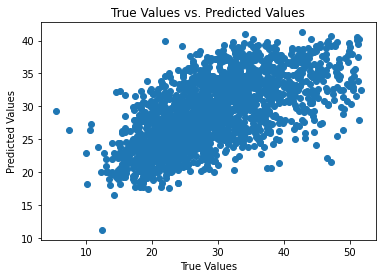

In [173]:
plt.scatter(y_test, predictions_test)

# 添加标签和标题
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Values vs. Predicted Values')

# 显示图表
plt.show()

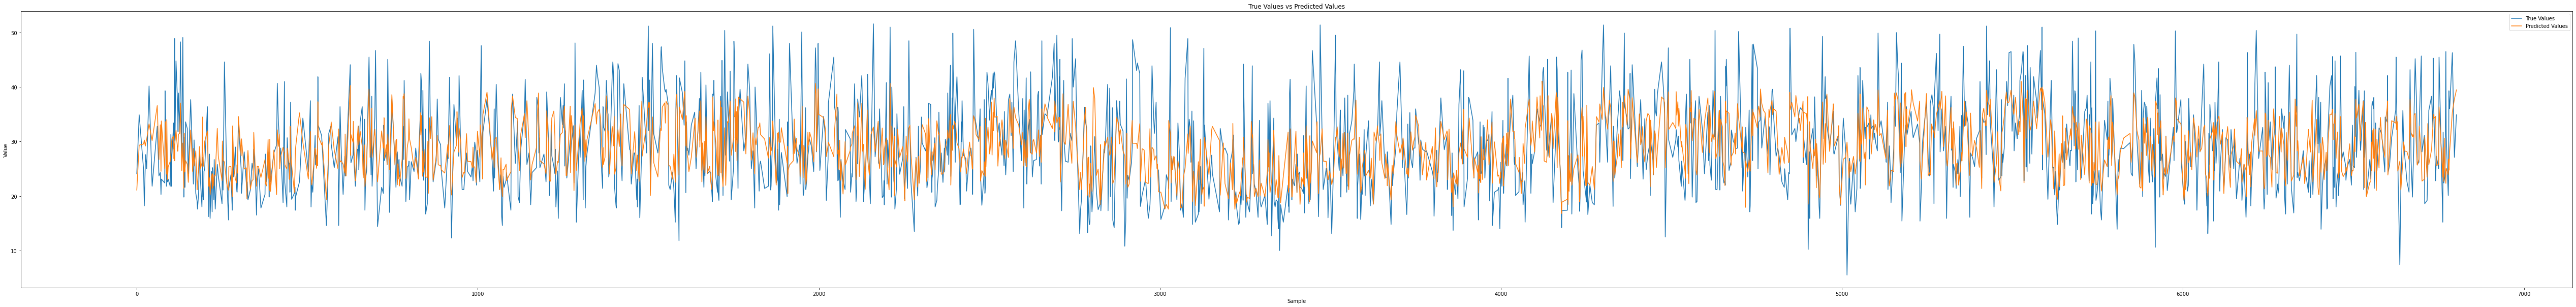

In [174]:
# 创建折线图
plt.figure(figsize=(90,10))
plt.plot(y_test, label='True Values')
plt.plot(y_test_pred, label='Predicted Values')

# 图表标题和标签
plt.title('True Values vs Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Value')

# 添加图例
plt.legend()

# 显示图表
plt.show()

In [175]:
metrics = predictor.evaluate(test_data, silent=True)

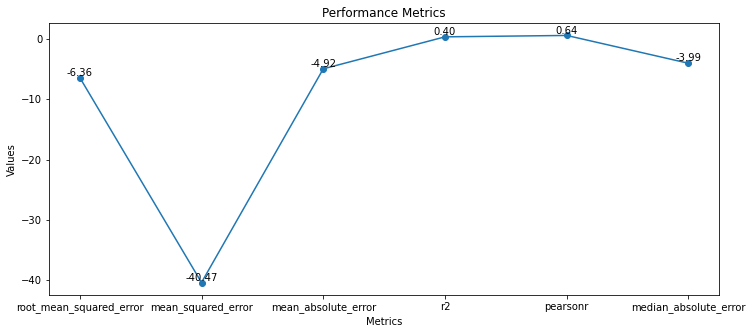

In [176]:
metric_names = list(metrics.keys())
metric_values = list(metrics.values())
plt.figure(figsize=(12,5))
plt.plot(metric_names, metric_values, marker='o')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Metrics')

# 标注数值
for i in range(len(metric_names)):
    plt.annotate(f'{metric_values[i]:.2f}', (metric_names[i], metric_values[i]), ha='center', va='bottom')

plt.show()


In [ ]:

def calculate_modified_r2(y_true, y_pred):
    diff = np.abs(y_true - y_pred)/y_true
    modified_diff = np.where(diff <= 0.15, 0, np.abs(y_true - y_pred))
    modified_ssr = np.sum(modified_diff**2)
    
    mean = np.mean(y_true)
    total_diff = np.sum((y_true - mean)**2)
    
    r2 = 1 - (modified_ssr / total_diff)
    return r2

print(calculate_modified_r2(test_data[label], y_test_pred))

In [ ]:
model_value = predictor.leaderboard(train_data, silent=True)

In [ ]:
fetures_value = predictor.feature_importance(train_data)
fetures_value

In [ ]:
fetures_value.shape

In [ ]:
fetures_value

In [ ]:
# 将索引添加为列

df = fetures_value
df.reset_index(level=0, inplace=True)
print(df)

In [ ]:
fetures_value.columns

In [ ]:
import matplotlib.pyplot as plt

# 设置图表大小
plt.figure(figsize=(50, 40))

# 绘制各个特征的重要性
plt.subplot(3, 2, 1)
plt.bar(df['index'], df['importance'])
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')

# 绘制各个特征的标准差
plt.subplot(3, 2, 2)
plt.bar(df['index'], df['stddev'])
plt.title('Standard Deviation')
plt.xlabel('Feature')
plt.ylabel('Stddev')

# 绘制各个特征的p值
plt.subplot(3, 2, 3)
plt.bar(df['index'], df['p_value'])
plt.title('P-value')
plt.xlabel('Feature')
plt.ylabel('P-value')

# 绘制各个特征的p99高值
plt.subplot(3, 2, 4)
plt.bar(df['index'], df['p99_high'])
plt.title('P99 High')
plt.xlabel('Feature')
plt.ylabel('P99 High')

# 绘制各个特征的p99低值
plt.subplot(3, 2, 5)
plt.bar(df['index'], df['p99_low'])
plt.title('P99 Low')
plt.xlabel('Feature')
plt.ylabel('P99 Low')

# 调整子图之间的间距
plt.tight_layout()

# 展示图表
plt.show()


In [ ]:
"""importance（重要性）：

取值范围：通常是一个非负实数，可以是介于0到无穷大之间的任意值。
意义：表示该特征对目标变量的预测能力的贡献程度。重要性值越高，说明该特征在预测模型中的影响力越大。
stddev（标准差）：

取值范围：通常是一个非负实数，可以是大于等于0的任意值。
意义：衡量特征值分散程度的统计指标。标准差值越大，表示样本数据在该特征上的波动越大。
p_value（P值）：

取值范围：通常是一个小于等于1的实数，可能是非负实数或者在特定情况下限制在0到1之间的实数。
意义：用于判断某个变量对目标变量是否具有显著影响。较小的p-value表示该特征与目标变量之间的关系更显著。
n（样本数量）：

取值范围：通常是一个正整数，表示用于计算这些特征参数的样本数量。
意义：表示用于计算特征参数的数据样本的数量。
p99_high（99%置信度上限）和p99_low（99%置信度下限）：

取值范围：通常是实数，可以是任意实数或在特定情况下限制在一定范围内的实数。
意义：表示特征的置信区间。在统计意义下，特征取值不会超过上限或低于下限的概率为99%。"""